In [1]:
import numpy as np
import seaborn as sns
import optuna
import plotly
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import fbeta_score, f1_score, make_scorer, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, auc, mean_squared_error, r2_score

from utils.data_loader import load_split, prepare_features_target
from utils.learning_curve import learning_curve_with_resampling
from models.manage_models import save_model

c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
f2_scorer = make_scorer(fbeta_score, beta=2)

In [3]:
train_df = load_split('train', data_dir='dataset/splits')
X_train, y_train = prepare_features_target(train_df, target_col='Fault')

In [4]:
def objective(trial):

    sampling_strategy = trial.suggest_categorical("sampling", ["none", "smote", "under"])
    
    c_param = trial.suggest_categorical("C", [0.01, 0.1, 1, 5, 10])
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])
    solver = trial.suggest_categorical("solver", ["lbfgs", "newton-cg", "sag", "newton-cholesky", "liblinear", "saga"])

    l1_ratio = None
    if solver in ["lbfgs", "newton-cg", "sag", "newton-cholesky"]:
        penalty = trial.suggest_categorical("penalty_g1", ["l2"])
    elif solver == "liblinear":
        penalty = trial.suggest_categorical("penalty_g2", ["l1", "l2"])
    elif solver == "saga":
        penalty = "elasticnet"
        l1_ratio = trial.suggest_categorical("l1_ratio", [0, 0.5, 1])

    steps = [('scaler', StandardScaler())]

    if sampling_strategy == "smote":
        steps.append(('resample', SMOTE(random_state=42)))
    elif sampling_strategy == "under":
        steps.append(('resample', RandomUnderSampler(random_state=42)))
    
    clf = LogisticRegression(
        C=c_param, penalty=penalty, solver=solver,
        class_weight=class_weight, l1_ratio=l1_ratio,
        max_iter=2000, random_state=42
    )
    steps.append(('clf', clf))

    pipeline = ImbPipeline(steps)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=f2_scorer, n_jobs=-1)
    
    return scores.mean()

In [5]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100) # Con 50 pruebas suele bastar para LogReg

print(f"Mejor score (f2_scorer): {study.best_value}")
print(f"Mejores parámetros: {study.best_params}")

[I 2025-12-21 11:01:50,247] A new study created in memory with name: no-name-c0840b00-1f24-4953-96e3-d7bc7f0982fe
[I 2025-12-21 11:01:54,363] Trial 0 finished with value: 0.807194978218579 and parameters: {'sampling': 'smote', 'C': 0.1, 'class_weight': None, 'solver': 'newton-cholesky', 'penalty_g1': 'l2'}. Best is trial 0 with value: 0.807194978218579.
[I 2025-12-21 11:01:57,028] Trial 1 finished with value: 0.7204247210060224 and parameters: {'sampling': 'none', 'C': 5, 'class_weight': None, 'solver': 'saga', 'l1_ratio': 1}. Best is trial 0 with value: 0.807194978218579.
[I 2025-12-21 11:01:59,437] Trial 2 finished with value: 0.8183421730816063 and parameters: {'sampling': 'under', 'C': 5, 'class_weight': None, 'solver': 'saga', 'l1_ratio': 1}. Best is trial 2 with value: 0.8183421730816063.
[I 2025-12-21 11:02:02,423] Trial 3 finished with value: 0.8165030334753816 and parameters: {'sampling': 'smote', 'C': 5, 'class_weight': 'balanced', 'solver': 'liblinear', 'penalty_g2': 'l2'}. 

Mejor score (f2_scorer): 0.8183482297800058
Mejores parámetros: {'sampling': 'under', 'C': 10, 'class_weight': None, 'solver': 'saga', 'l1_ratio': 1}


In [6]:
df = study.trials_dataframe()

In [7]:
df['params_penalty_unified'] = df['params_penalty_g1'].fillna(df['params_penalty_g2'])
df.loc[df['params_solver'] == 'saga', 'params_penalty_unified'] = 'elasticnet'

In [8]:
df.head()

,number,value,datetime_start,datetime_complete,duration,params_C,params_class_weight,params_l1_ratio,params_penalty_g1,params_penalty_g2,params_sampling,params_solver,state,params_penalty_unified
0,0,0.807195,2025-12-21 11:01:50.248294,2025-12-21 11:01:54.363500,0 days 00:00:04.115206,0.1,None,NaN,l2,NaN,smote,newton-cholesky,COMPLETE,l2
1,1,0.720425,2025-12-21 11:01:54.365287,2025-12-21 11:01:57.027904,0 days 00:00:02.662617,5.0,None,1.0,NaN,NaN,none,saga,COMPLETE,elasticnet
2,2,0.818342,2025-12-21 11:01:57.029977,2025-12-21 11:01:59.437836,0 days 00:00:02.407859,5.0,None,1.0,NaN,NaN,under,saga,COMPLETE,elasticnet
3,3,0.816503,2025-12-21 11:01:59.439938,2025-12-21 11:02:02.423817,0 days 00:00:02.983879,5.0,balanced,NaN,NaN,l2,smote,liblinear,COMPLETE,l2
4,4,0.815808,2025-12-21 11:02:02.425769,2025-12-21 11:02:02.801465,0 days 00:00:00.375696,1.0,balanced,NaN,l2,NaN,under,newton-cg,COMPLETE,l2


In [9]:
optuna.visualization.plot_optimization_history(study)

In [10]:
optuna.visualization.plot_param_importances(study)

In [11]:
optuna.visualization.plot_contour(study, params=["solver", "C"])

In [12]:
optuna.visualization.plot_contour(study, params=["class_weight", "sampling"])

In [13]:
params = study.best_params.copy()

penalty_value = params.pop('penalty_g1', params.pop('penalty_g2', None))

if params.get('solver') == 'saga':
    params['penalty'] = 'elasticnet'
else:
    params['penalty'] = None if penalty_value == "none" else penalty_value

sampling = params.pop('sampling')

print("Parámetros finales para el modelo:", params)

Parámetros finales para el modelo: {'C': 10, 'class_weight': None, 'solver': 'saga', 'l1_ratio': 1, 'penalty': 'elasticnet'}


In [14]:
best_clf = LogisticRegression(**params, max_iter=5000, random_state=42)

In [15]:
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', best_clf)
])

Curva de aprendizaje

under


Folds CV:   0%|          | 0/5 [00:00<?, ?it/s]


Fold 1/5
Datos originales -> Train: 64000, Val: 16000
Distribución clase 1 -> Train: 19840, Val: 4960
  Tamaño 6400 -> Resampling: 6400 → 3968 muestras
  Tamaño 6400 -> Train F2: 0.8606, Val F2: 0.8220
  Tamaño 14628 -> Resampling: 14628 → 9070 muestras
  Tamaño 14628 -> Train F2: 0.8615, Val F2: 0.8227
  Tamaño 22857 -> Resampling: 22857 → 14172 muestras
  Tamaño 22857 -> Train F2: 0.8597, Val F2: 0.8231
  Tamaño 31085 -> Resampling: 31085 → 19272 muestras
  Tamaño 31085 -> Train F2: 0.8576, Val F2: 0.8213
  Tamaño 39314 -> Resampling: 39314 → 24374 muestras
  Tamaño 39314 -> Train F2: 0.8582, Val F2: 0.8210
  Tamaño 47542 -> Resampling: 47542 → 29476 muestras
  Tamaño 47542 -> Train F2: 0.8565, Val F2: 0.8225
  Tamaño 55771 -> Resampling: 55771 → 34578 muestras
  Tamaño 55771 -> Train F2: 0.8564, Val F2: 0.8212
  Tamaño 64000 -> Resampling: 64000 → 39680 muestras


Folds CV:  20%|██        | 1/5 [00:02<00:10,  2.71s/it]

  Tamaño 64000 -> Train F2: 0.8575, Val F2: 0.8217

Fold 2/5
Datos originales -> Train: 64000, Val: 16000
Distribución clase 1 -> Train: 19840, Val: 4960
  Tamaño 6400 -> Resampling: 6400 → 3968 muestras
  Tamaño 6400 -> Train F2: 0.8596, Val F2: 0.8198
  Tamaño 14628 -> Resampling: 14628 → 9070 muestras
  Tamaño 14628 -> Train F2: 0.8600, Val F2: 0.8224
  Tamaño 22857 -> Resampling: 22857 → 14172 muestras
  Tamaño 22857 -> Train F2: 0.8575, Val F2: 0.8225
  Tamaño 31085 -> Resampling: 31085 → 19272 muestras
  Tamaño 31085 -> Train F2: 0.8627, Val F2: 0.8235
  Tamaño 39314 -> Resampling: 39314 → 24374 muestras
  Tamaño 39314 -> Train F2: 0.8585, Val F2: 0.8228
  Tamaño 47542 -> Resampling: 47542 → 29476 muestras
  Tamaño 47542 -> Train F2: 0.8574, Val F2: 0.8220
  Tamaño 55771 -> Resampling: 55771 → 34578 muestras
  Tamaño 55771 -> Train F2: 0.8563, Val F2: 0.8213
  Tamaño 64000 -> Resampling: 64000 → 39680 muestras


Folds CV:  40%|████      | 2/5 [00:05<00:08,  2.75s/it]

  Tamaño 64000 -> Train F2: 0.8583, Val F2: 0.8214

Fold 3/5
Datos originales -> Train: 64000, Val: 16000
Distribución clase 1 -> Train: 19840, Val: 4960
  Tamaño 6400 -> Resampling: 6400 → 3968 muestras
  Tamaño 6400 -> Train F2: 0.8550, Val F2: 0.8129
  Tamaño 14628 -> Resampling: 14628 → 9070 muestras
  Tamaño 14628 -> Train F2: 0.8636, Val F2: 0.8177
  Tamaño 22857 -> Resampling: 22857 → 14172 muestras
  Tamaño 22857 -> Train F2: 0.8592, Val F2: 0.8170
  Tamaño 31085 -> Resampling: 31085 → 19272 muestras
  Tamaño 31085 -> Train F2: 0.8613, Val F2: 0.8177
  Tamaño 39314 -> Resampling: 39314 → 24374 muestras
  Tamaño 39314 -> Train F2: 0.8595, Val F2: 0.8168
  Tamaño 47542 -> Resampling: 47542 → 29476 muestras
  Tamaño 47542 -> Train F2: 0.8615, Val F2: 0.8179
  Tamaño 55771 -> Resampling: 55771 → 34578 muestras
  Tamaño 55771 -> Train F2: 0.8575, Val F2: 0.8146
  Tamaño 64000 -> Resampling: 64000 → 39680 muestras


Folds CV:  60%|██████    | 3/5 [00:08<00:05,  2.67s/it]

  Tamaño 64000 -> Train F2: 0.8588, Val F2: 0.8187

Fold 4/5
Datos originales -> Train: 64000, Val: 16000
Distribución clase 1 -> Train: 19840, Val: 4960
  Tamaño 6400 -> Resampling: 6400 → 3968 muestras
  Tamaño 6400 -> Train F2: 0.8485, Val F2: 0.8139
  Tamaño 14628 -> Resampling: 14628 → 9070 muestras
  Tamaño 14628 -> Train F2: 0.8543, Val F2: 0.8157
  Tamaño 22857 -> Resampling: 22857 → 14172 muestras
  Tamaño 22857 -> Train F2: 0.8613, Val F2: 0.8162
  Tamaño 31085 -> Resampling: 31085 → 19272 muestras
  Tamaño 31085 -> Train F2: 0.8573, Val F2: 0.8177
  Tamaño 39314 -> Resampling: 39314 → 24374 muestras
  Tamaño 39314 -> Train F2: 0.8584, Val F2: 0.8167
  Tamaño 47542 -> Resampling: 47542 → 29476 muestras
  Tamaño 47542 -> Train F2: 0.8575, Val F2: 0.8160
  Tamaño 55771 -> Resampling: 55771 → 34578 muestras
  Tamaño 55771 -> Train F2: 0.8583, Val F2: 0.8162
  Tamaño 64000 -> Resampling: 64000 → 39680 muestras


Folds CV:  80%|████████  | 4/5 [00:10<00:02,  2.67s/it]

  Tamaño 64000 -> Train F2: 0.8579, Val F2: 0.8148

Fold 5/5
Datos originales -> Train: 64000, Val: 16000
Distribución clase 1 -> Train: 19840, Val: 4960
  Tamaño 6400 -> Resampling: 6400 → 3968 muestras
  Tamaño 6400 -> Train F2: 0.8553, Val F2: 0.8128
  Tamaño 14628 -> Resampling: 14628 → 9070 muestras
  Tamaño 14628 -> Train F2: 0.8551, Val F2: 0.8094
  Tamaño 22857 -> Resampling: 22857 → 14172 muestras
  Tamaño 22857 -> Train F2: 0.8583, Val F2: 0.8121
  Tamaño 31085 -> Resampling: 31085 → 19272 muestras
  Tamaño 31085 -> Train F2: 0.8610, Val F2: 0.8154
  Tamaño 39314 -> Resampling: 39314 → 24374 muestras
  Tamaño 39314 -> Train F2: 0.8614, Val F2: 0.8152
  Tamaño 47542 -> Resampling: 47542 → 29476 muestras
  Tamaño 47542 -> Train F2: 0.8614, Val F2: 0.8151
  Tamaño 55771 -> Resampling: 55771 → 34578 muestras
  Tamaño 55771 -> Train F2: 0.8598, Val F2: 0.8145
  Tamaño 64000 -> Resampling: 64000 → 39680 muestras


Folds CV: 100%|██████████| 5/5 [00:13<00:00,  2.70s/it]

  Tamaño 64000 -> Train F2: 0.8589, Val F2: 0.8150


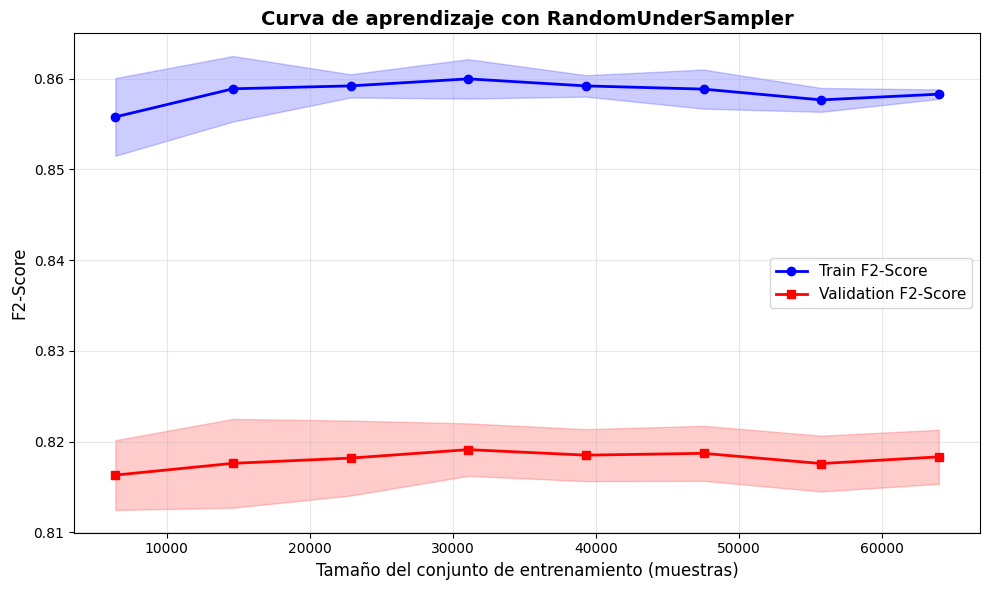


RESUMEN DE LA CURVA DE APRENDIZAJE
Mejor tamaño de entrenamiento: 31085 muestras
Mejor F2-Score en validación: 0.8191 (±0.0029)
F2-Score correspondiente en train: 0.8600
Técnica de resampling: RandomUnderSampler


In [16]:
if sampling == 'smote':
    print("smote")
    sampler = SMOTE(random_state=42, k_neighbors=min(5, (y_train == 1).sum() - 1))
elif sampling == 'under':
    print("under")
    sampler = RandomUnderSampler(random_state=42)

result = learning_curve_with_resampling(
    estimator=final_pipeline,
    X=X_train,
    y=y_train,
    sampler=sampler,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv=5,
    verbose=True,
    use_tqdm=True
)

In [17]:
if sampling == 'smote':
    print("smote")
    smote = SMOTE(random_state=42, k_neighbors=min(5, (y_train == 1).sum() - 1))
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    final_pipeline.fit(X_train_smote, y_train_smote)
elif sampling == 'under':
    print("under")
    rus = RandomUnderSampler(random_state=42)
    X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
    final_pipeline.fit(X_train_under, y_train_under)
else:
    final_pipeline.fit(X_train, y_train)

under
